# Protein Data Analysis
This notebook analyzes protein data, focusing on properties like mass and presence of PDB structures.

## Section 1: Data Loading and Initial Exploration

In [2]:

import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
file_path = 'uniprotkb_NOT_cc_scl_term_SL_0162_AND_r_2024_02_08.tsv'
protein_df = pd.read_csv(file_path, sep='\t')

# Display the first few rows to understand the dataset
print(protein_df.head(3))

# Show specific columns to get a sense of the data
print(protein_df[['Entry', 'Organism (ID)', 'Length']].head(3))


        Entry   Entry Name                                      Protein names  \
0  A0A009IHW8  ABTIR_ACIB9  2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...   
1  A0A023I7E1   ENG1_RHIMI  Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...   
2  A0A024SC78  CUTI1_HYPJR                             Cutinase (EC 3.1.1.74)   

                                            Organism  Organism (ID)  \
0           Acinetobacter baumannii (strain 1295743)        1310613   
1                                  Rhizomucor miehei           4839   
2  Hypocrea jecorina (strain ATCC 56765 / BCRC 32...        1344414   

                                                  3D                   PDB  \
0  Electron microscopy (1); X-ray crystallography...       7UWG;7UXU;8G83;   
1                          X-ray crystallography (4)  4K35;4K3A;5XBZ;5XC2;   
2                          X-ray crystallography (3)       4PSC;4PSD;4PSE;   

    Mass  Length  
0  30922     269  
1  89495     796  
2  25924     248  
 

## Section 2: Data Analysis

In [3]:

# Count the total number of proteins
total_proteins = protein_df.shape[0]
print('Total count:', total_proteins)

# Filter proteins with a PDB structure
proteins_with_pdb = protein_df[protein_df['PDB'].notna()]
print('Proteins with PDB:', proteins_with_pdb.shape[0])

# Further filter proteins by mass range (1000 to 50000 Da)
filtered_proteins = proteins_with_pdb[(proteins_with_pdb['Mass'] > 1000) & (proteins_with_pdb['Mass'] < 50000)]
print('Proteins with PDB and mass < 50kDa:', filtered_proteins.shape[0])


Total count: 453600
Proteins with PDB: 26253
Proteins with PDB and mass < 50kDa: 18697


## Section 3: Data Visualization

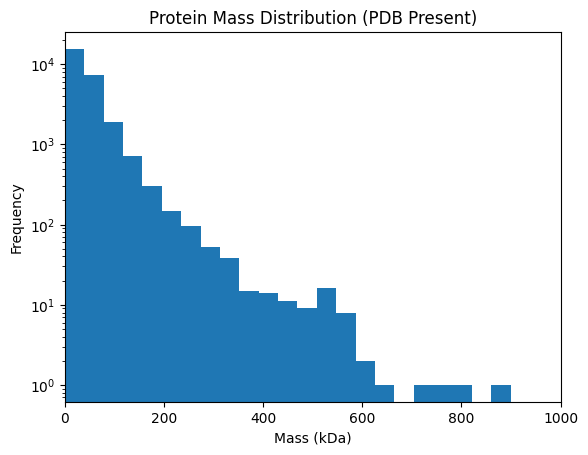

In [4]:

import pandas as pd
import matplotlib.pyplot as plt

# Calculate mass in kDa
proteins_with_pdb_in_kDa = proteins_with_pdb.copy()
proteins_with_pdb_in_kDa['Mass_kDa'] = proteins_with_pdb['Mass'] / 1000

# Plot the mass distribution of proteins with a PDB structure
proteins_with_pdb_in_kDa['Mass_kDa'].plot(kind='hist', bins=100, logy=True, title='Protein Mass Distribution (PDB Present)')
plt.xlabel('Mass (kDa)')
plt.ylabel('Frequency')
plt.xlim(0, 1000)
plt.show()


## Section 4: Get a list of PDB codes

In [ ]:
# Clean up 'PDB' column by removing trailing semicolons and replacing semicolons with commas
df_cleaned = proteins_with_pdb.copy()
df_cleaned['PDB'] = df_cleaned['PDB'].apply(lambda x: x.strip(';').replace(';', ','))

# Merge all PDB entries into a single comma-separated string and split into a list
pdb_comma_separated = ','.join(df_cleaned['PDB'])
pdb_list = pdb_comma_separated.split(',')
pdb_list = list(set(pdb_list))

# Print the total number of unique PDB entries
print('Total number of PDBs:', len(pdb_list))
print('Peek: ',pdb_list[:10])

#Find if any antry has a PDB repeated and write the entries and the repeated PDB
count_simple = 0
count_multiple = 0

for pdb in pdb_list:
    entry = df_cleaned[df_cleaned['PDB'].str.contains(pdb, na=False)]['Entry'].values
    if len(entry) > 1:
        count_multiple += 1
    else:
        count_simple += 1
    print(count_simple, count_multiple) #Final: 95078 17478 (total 112556)

## Section 5: Download information from PDB

<strong> Caution! This takes a lot of time and multiple re-runs, and some file editing to restart the block. </strong> 

In [ ]:
# Retrieving and Recording PDB Entry Information
import requests
import datetime
import os
import pandas as pd

# Function to read already processed PDB codes from "already.tsv"
def read_already_processed(file_path):
    if os.path.exists(file_path):
        return set(pd.read_csv(file_path, sep='\t')['PDB'])
    else:
        return set()

# File with already processed PDBs
already_file = 'merged_pdb_info_2024-02-10_00-58-55.tsv'
already_processed = read_already_processed(already_file)

# Current time for file naming, to ensure the file name is unique
now = datetime.datetime.now()
file_name = f'pdb_info_{now.strftime("%Y-%m-%d_%H-%M-%S")}.tsv'

# Function to fetch data for a single PDB entry
def fetch_pdb_data(pdb):
    url = f'https://data.rcsb.org/rest/v1/core/entry/{pdb}'
    response = requests.get(url)
    if response.status_code == 200:
        print(f'{pdb} ... OK')
        return response.json()
    else:
        print(f'Warning: PDB {pdb} was not found')
        return None

# Function to extract and format the required information from the response
def extract_info(json_data, pdb):
    if json_data:
        pubmed_id = json_data.get('rcsb_entry_container_identifiers', {}).get('pubmed_id', 'null')
        deposit_date = json_data['rcsb_accession_info']['deposit_date'].split('T')[0]
        model_count = json_data['rcsb_entry_info']['deposited_model_count']
        molecular_weight = json_data['rcsb_entry_info']['molecular_weight']
        polymer_type = json_data['rcsb_entry_info']['selected_polymer_entity_types']
        modeled_residues = json_data['rcsb_entry_info']['deposited_modeled_polymer_monomer_count']
        total_residues = json_data['rcsb_entry_info']['deposited_polymer_monomer_count']
        coverage = int(modeled_residues / total_residues * 100)
        return f'{pdb}\t{pubmed_id}\t{deposit_date}\t{model_count}\t{molecular_weight}\t{polymer_type}\t{modeled_residues}\t{total_residues}\t{coverage}\n'
    else:
        return f'{pdb}\tError fetching data\n'
    
# Writing the header and data to a file
with open(file_name, 'w') as f:
    # Writing the header directly
    f.write('PDB\tPubmed_ID\tDeposit_date\tModel_count\tMolecular_weight\tPolymer_type\tModeled_residues\tTotal_residues\tCoverage\n')

    for pdb in pdb_list:
        if pdb not in already_processed:
            json_data = fetch_pdb_data(pdb)
            info_line = extract_info(json_data, pdb)
            f.write(info_line)
            
        else:
            pass
            print(f'{pdb} skipped')
    
